(([], []), ([], []))

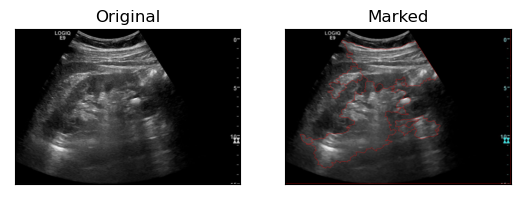

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

s = r'C:\Users\User\cv projects\Kidney-Stone-Detection-main\images'
image_no = '\image_8.jpg'
s = s + image_no

img = cv2.imread(s,0)
plt.subplot(121),plt.imshow(img,'gray')
plt.title('Original')
plt.xticks([]),plt.yticks([])
def build_filters():
    #returns a list of kernels in several orientations
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 32):
        params = {'ksize': (ksize, ksize), 'sigma': 0.0225, 'theta': theta, 'lambd': 15.0,
                  'gamma': 0.01, 'psi': 0, 'ktype': cv2.CV_32F}
        
        kern = cv2.getGaborKernel(**params)
        kern /= 1.5*kern.sum()
        filters.append((kern, params))
    return filters


def process(img, filters):
    #returns the img filtered by the filter list
    accum = np.zeros_like(img)
    for kern, params in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        np.maximum(accum, fimg, accum)
    return accum

def AdaptiveHistEq(img):
    aeq = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equ = aeq.apply(img)
    return equ

def GaborFilter(img):
    filters = build_filters()
    p = process(img, filters)
    return p

def Laplacian(img,par):  
    lap = cv2.Laplacian(img,cv2.CV_64F)
    sharp = img - par*lap
    sharp = np.uint8(cv2.normalize(sharp, None, 0 , 255, cv2.NORM_MINMAX))
    return sharp

def Watershed(img):
    ret, thresh = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.23*dist_transform.max(),255,0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    
    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1

    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0

    img2 = cv2.imread(s,1)
    img2 = cv2.medianBlur(img2,5)
    markers = cv2.watershed(img2,markers)
    img2[markers == -1] = [255,0,0]

    return img2

if image_no=='\image1.jpg':
    img3 = Laplacian(img,0.239)
    
elif image_no=='\image2.jpg':
    img3 = GaborFilter(img)
    img3 = AdaptiveHistEq(img3)

elif image_no=='\image3.jpg':
    img3 = GaborFilter(img)

img3 = Watershed(img)
plt.subplot(122),plt.imshow(img3,'gray')
plt.title('Marked')
plt.xticks([]),plt.yticks([])
